In [1]:
#command-lines for the dependencies
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install catboost
!pip install missingno


    100% |████████████████████████████████| 60.6MB 606kB/s 


In [2]:
#uploading kaggle API
!pip install kaggle

#uploading the kaggle.json (API) file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bornrmi","key":"bb3702abb72f5b57b4b06ec34e89775c"}'}

In [3]:
#for accessing the datasets directly in colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 23.5MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.9MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.10MB/s]


In [4]:
#command to see all the available files 
!ls

gender_submission.csv  kaggle.json  sample_data  test.csv  train.csv


In [0]:
#importing dependencies
%matplotlib inline

#python imports
import math, random, datetime, time

#data manupulation
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

#preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection,tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#importing train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [7]:
#viewing the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
#total length of the data
len(train)

891

In [9]:
#viewing the test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
#similarly for gender submission
gender_submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# **Data Description**
---
Survival: 0 = No, 1 = Yes

pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic

parch: number of parents/children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton




In [11]:
#describing training data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


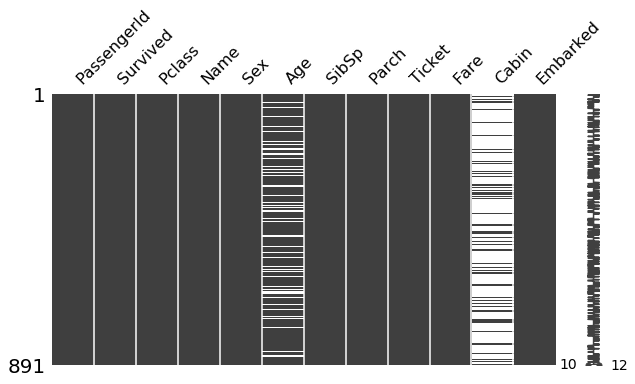

In [12]:
#finding the missing values from the data set 
#missing values have NaN instead of real values
missingno.matrix(train, figsize=(10,5))

There are some missing values in the age and cabin section.

Visualising the misssing values in the data set gives a clear picture of the dataset.

This information will help out in the EDA and data preprocessing.

In [13]:
#function to show us how many missing values are there
def find_missing_values(df, columns):
  """
  Finds the number of rows where certain columns have missing values.
  ::parameter_df:: = target dataframe
  ::parameter_columns:: = list of the columns
  """
  
  missing_vals ={}
  print("Number of NaN values for each column:")
  df_length = len(df)
  for column in columns:
    total_column_values = df[column].value_counts().sum()
    missing_vals[column] = df_length - total_column_values
    #missing_vals.append(str(column)+ "column has {} missing or NaN values.".format())
  return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values 

Number of NaN values for each column:


{'Age': 177,
 'Cabin': 687,
 'Embarked': 2,
 'Fare': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [0]:
#creating some dataframes to access continuous variables and the discretised continuous variables

df_dis = pd.DataFrame() #for discretised continuous variables
df_con = pd.DataFrame() #for continuous variables

In [15]:
#different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [16]:
#Looking at the train data once again to explore each feature seperately

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


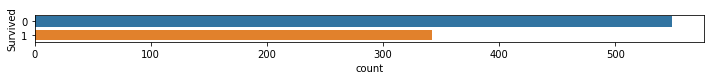

In [17]:
#survial data
#how many people survived?
fig = plt.figure(figsize=(12,0.5))
sns.countplot(y="Survived", data=train);
print(train.Survived.value_counts())

In [0]:
#Let's add this to subset dataframes
df_dis['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [19]:
df_dis.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [20]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


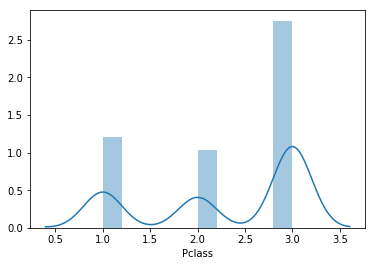

In [21]:
sns.distplot(train.Pclass)

In [22]:
missing_values['Pclass']

0

In [0]:
#Let's add this to subset dataframes
df_dis['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [24]:
df_dis.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [25]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [26]:
#Name Feature of the passenger
#Does name repeats

train.Name.value_counts()

#so name feature is Unique

Andersson, Master. Sigvard Harald Elias                     1
Serepeca, Miss. Augusta                                     1
Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)     1
Duran y More, Miss. Asuncion                                1
Osen, Mr. Olaf Elon                                         1
Bissette, Miss. Amelia                                      1
Lefebre, Master. Henry Forbes                               1
Giglio, Mr. Victor                                          1
Radeff, Mr. Alexander                                       1
LeRoy, Miss. Bertha                                         1
Todoroff, Mr. Lalio                                         1
Hoyt, Mr. William Fisher                                    1
Sheerlinck, Mr. Jan Baptist                                 1
Johnston, Mr. Andrew G                                      1
McDermott, Miss. Brigdet Delia                              1
Cairns, Mr. Alexander                                       1
Simmons,

male      577
female    314
Name: Sex, dtype: int64


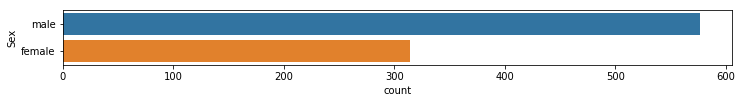

In [27]:
#sex feature of the given dataset
fig = plt.figure(figsize=(12,1))
sns.countplot(y="Sex", data=train)
print(train.Sex.value_counts())

In [28]:
#are there any missing values in the sex feature
missing_values["Sex"]

0

In [29]:
train.Sex.head()


0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [0]:
#adding sex to the subset dataframes
df_dis['Sex'] = train['Sex']
df_dis['Sex'] = np.where(df_dis['Sex'] == 'female',1,0) #changing the female values to 1 while male value to 0

df_con["Sex"] = train["Sex"]


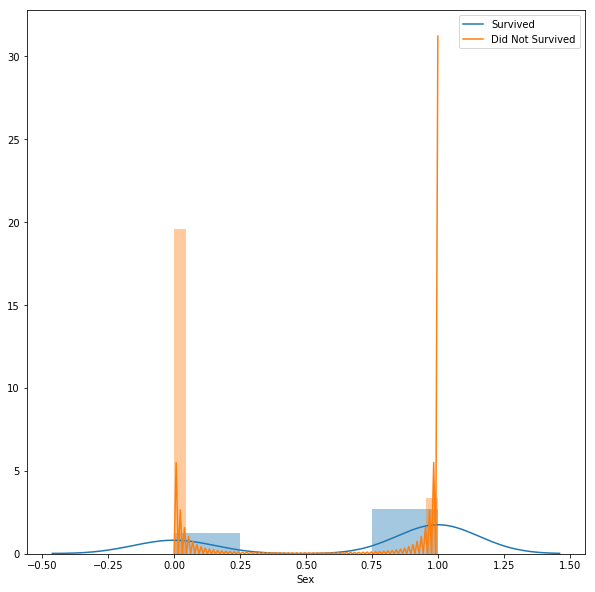

In [31]:
#comparing sex variable to the survival variable
#we can compare them both as they are binary now
fig = plt.figure(figsize=(10,10))
sns.distplot(df_dis.loc[df_dis['Survived'] ==1]['Sex'], kde_kws={'label':'Survived'})
sns.distplot(df_dis.loc[df_dis['Survived'] ==0]['Sex'], kde_kws={'label':'Did Not Survived'})



This tells us that more female survived as compared to males out of the total number of survivals.

In [32]:
#age feature

#number of missing values in the age column
missing_values['Age']

177

In [0]:
#thus we have to fill almost one quarter of values in the Age column
#and then adding all the age values to our DataFrame

#df_dis["Age"] = pd.cut(train['Age'],10) #bucketed/binned into different categories
#df_con["Age"] = train['Age'] #non-bucketed

In [0]:
#function to create count and distribution visualisation

def plot_count_dist(data, bin_df, label_column, target_column, figsize=(15,5), use_bin_df=False):
  """
  Function to plot counts and distributions of a label variable and target variable side by side.
  ::param_data:: = target dataframe
  ::param_bin_df:: = binned dataframe for countplot
  ::param_label_column:: = binary labelled column
  ::param_target_column:: = column you want to view counts and distributions
  ::param_figsize:: = size of the figure (width, height)
  ::param_use_bin_df:: = whether or not to use the bin_df, default False 
  """
  
  if use_bin_df:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.countplot(y=target_column, data=bin_df);
    plt.subplot(1,2,2)
    sns.distplot(data.loc[data[label_column]==1][target_column], kde_kws={"label":"Survived"});
    sns.distplot(data.loc[data[label_column]==0][target_column], kde_kws={"label":"Did Not Survive"});
  
  else:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.countplot(y=target_column, data=data);
    plt.subplot(1,2,2)
    sns.distplot(data.loc[data[label_column] == 1][target_column], kde_kws={'label': 'Survived'});
    sns.distplot(data.loc[data[label_column] == 0][target_column], kde_kws={'label': 'Did not survived'});
    

In [35]:
#sibling feature
#no of missing values in the sibling column
missing_values['SibSp']

0

In [36]:
#number of siblings in the sibling column
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [0]:
# adding SibSp to the dataframes
df_dis['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

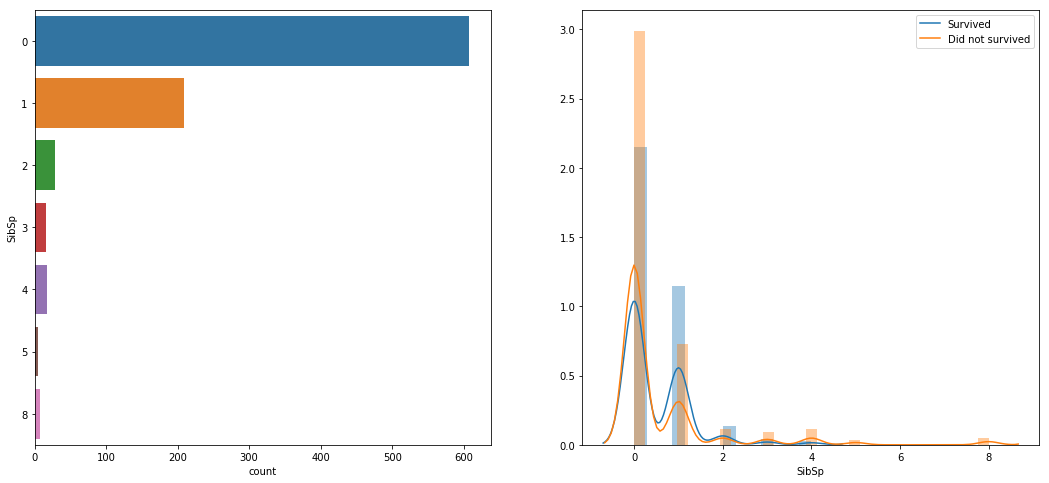

In [38]:
#Visualise the counts of SibSp and the distribution of the values against survived
plot_count_dist(train, bin_df=df_dis, label_column='Survived', target_column='SibSp', figsize=(18,8))

In [39]:
#Feature: Parch (number of parent/children)
#missing values
missing_values['Parch']

0

In [40]:
#what values are there
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [0]:
#adding parch to the subset dataframe
df_dis["Parch"] = train["Parch"]
df_con["Parch"] = train["Parch"]

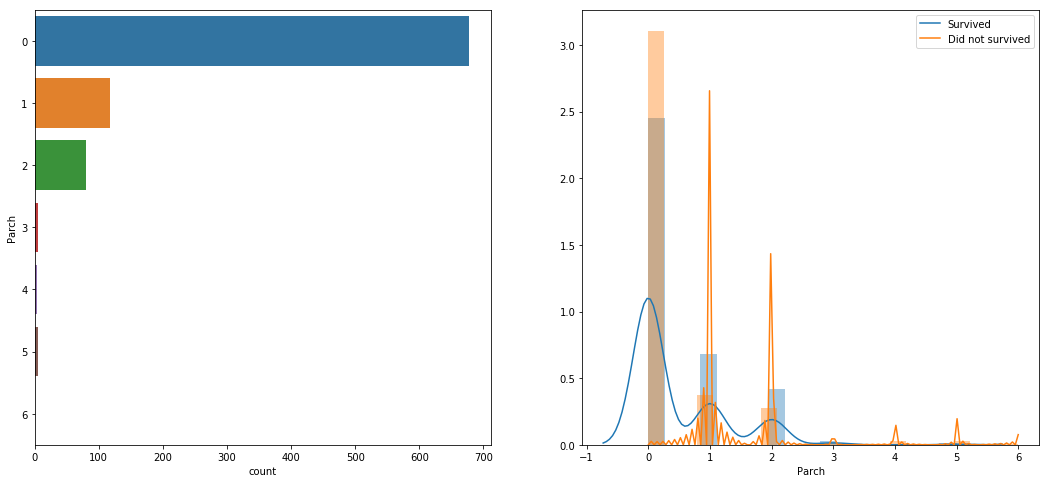

In [42]:
#visualising the counts of Parch and the distribution of the values against Survived
plot_count_dist(train, bin_df=df_dis, label_column="Survived", target_column="Parch", figsize=(18,8))

In [43]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


In [44]:
#feature ticket
#missing values in the ticket
missing_values['Ticket']

0

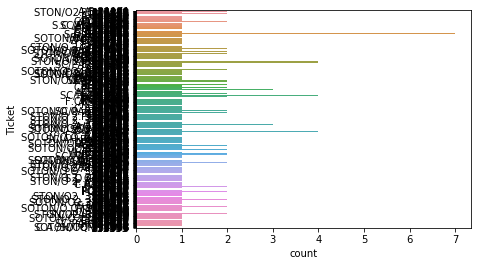

In [45]:
#how many kinds of ticket are there?
#fig = plt.figure(figsize=(15,150))
sns.countplot(y='Ticket', data=train);



In [46]:
#types of tickets
train.Ticket.value_counts()

347082               7
CA. 2343             7
1601                 7
3101295              6
347088               6
CA 2144              6
382652               5
S.O.C. 14879         5
349909               4
347077               4
17421                4
2666                 4
W./C. 6608           4
113760               4
PC 17757             4
113781               4
4133                 4
LINE                 4
19950                4
248727               3
110413               3
PC 17582             3
13502                3
239853               3
110152               3
C.A. 34651           3
PC 17572             3
35273                3
371110               3
SC/Paris 2123        3
                    ..
F.C.C. 13528         1
350417               1
65306                1
2223                 1
2626                 1
C.A. 33111           1
248723               1
349233               1
SC/PARIS 2133        1
113807               1
371060               1
347060               1
349231     

In [47]:
#how many unique kinds of tickets are there?
print('There are {} unique ticket values.'.format(len(train.Ticket.unique())))

There are 681 unique ticket values.


In [48]:
#feature: fare
missing_values["Fare"]

0

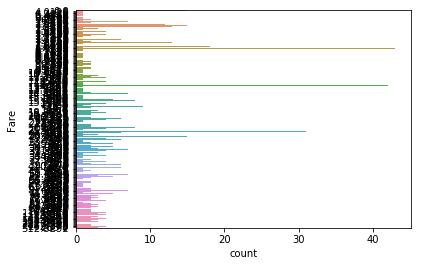

In [49]:
#how many different values of Fare are there?
#fig=plt.figure(figsize=(15,50))
sns.countplot(y='Fare', data=train);

In [50]:
#data type of the variable fare
train.Fare.dtype

dtype('float64')

In [51]:
#how many unique values of Fare are there
print("There are {} unique values of Fare".format(len(train.Fare.unique())))

There are 248 unique values of Fare


In [0]:
#add far to sub dataframes
df_con["Fare"] = train["Fare"]
df_dis["Fare"] = pd.cut(train["Fare"], bins=5) #discretised

In [53]:
df_dis.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

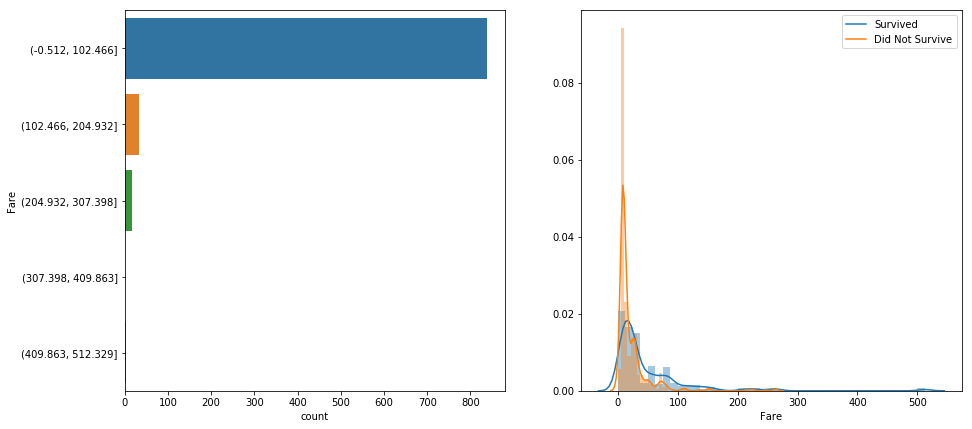

In [54]:
#visualise the fare dis counts as well as the fare distribution vs Survived
plot_count_dist(data=train, bin_df=df_dis, label_column="Survived", target_column="Fare", figsize=(15,7), use_bin_df=True)

In [55]:
#Feature Cabins
missing_values["Cabin"]

687

In [56]:
#How many cabin values are there
train.Cabin.value_counts()

B96 B98            4
G6                 4
C23 C25 C27        4
F33                3
C22 C26            3
D                  3
E101               3
F2                 3
B5                 2
C125               2
C126               2
B57 B59 B63 B66    2
F4                 2
C124               2
C83                2
E67                2
E121               2
E24                2
C93                2
C2                 2
E44                2
F G73              2
D17                2
D20                2
E25                2
C123               2
C65                2
B22                2
D36                2
C52                2
                  ..
E49                1
C148               1
C49                1
D50                1
B71                1
C86                1
E63                1
A32                1
C62 C64            1
E40                1
C54                1
D21                1
D48                1
C95                1
E10                1
C90                1
B101         

In [57]:
#Embarked Feature (place where passenger boarded the titanic)
#how many missing values are there
missing_values["Embarked"]

2

In [58]:
#how many types of values are there in the embarked
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

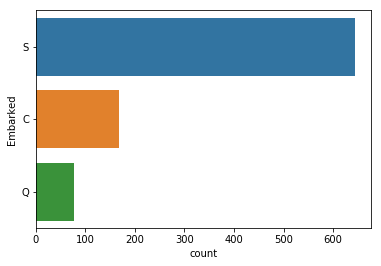

In [59]:
#representation of the embarked (C = Cherbourg, Q = Queenstown, S = Southampton)
sns.countplot(y="Embarked", data=train);

In [0]:
#adding the embarked to the sub dataframes
df_dis["Embarked"] = train["Embarked"]
df_con["Embarked"] = train["Embarked"]


In [61]:
#remove embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=["Embarked"])
df_dis = df_dis.dropna(subset=["Embarked"])
print(len(df_con))

891
889


In [62]:
#Feature encoding.
df_dis.head()


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [63]:
#one-hot encode binned variables
one_hot_cols = df_dis.columns.tolist()
one_hot_cols.remove("Survived")
df_dis_enc =pd.get_dummies(df_dis, columns=one_hot_cols)

df_dis_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [64]:
df_con.head(10)


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S
5,0,3,male,0,0,8.4583,Q
6,0,1,male,0,0,51.8625,S
7,0,3,male,3,1,21.0750,S
8,1,3,female,0,2,11.1333,S
9,1,2,female,1,0,30.0708,C


In [65]:
#Label Encode all continuous values using LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head(20)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2
5,0,2,1,0,0,51,1
6,0,0,1,0,0,186,2
7,0,2,1,3,1,124,2
8,1,2,0,0,2,74,2
9,1,1,0,1,0,154,0


In [66]:
#Start to build the machine learning models to fin which gives us out the best results
selected_df = df_con_enc

selected_df.head()


,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,18,2
1,1,0,0,1,0,207,0
2,1,2,0,0,0,41,2
3,1,0,0,1,0,189,2
4,0,2,1,0,0,43,2


In [0]:
#splitting the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) #data
Y_train = selected_df.Survived #labels

In [68]:
X_train.shape

(889, 6)

In [69]:
Y_train.shape

(889,)

In [0]:
#Define a function to fit machine learning algorithms (since we will be using the sklearn)
#Function to run machine learn algo and returns accuracy metrics

def fit_ml_algo(algo, X_train, Y_train, cv):
  
  #one pass
  model = algo.fit(X_train, Y_train)
  acc = round(model.score(X_train, Y_train)*100, 2)
  
  #cross Validation
  train_pred = model_selection.cross_val_predict(algo, X_train, Y_train, cv=cv, n_jobs=-1)
  
  #cross-validation accuracy metric
  acc_cv = round(metrics.accuracy_score(Y_train, train_pred) *100, 2)
  
  return train_pred, acc, acc_cv                                               

In [71]:
#Logistic Regression 
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), X_train, Y_train, 10)

log_time = (time.time() - start_time)

print("Accuracy:%s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running time %s" %datetime.timedelta(seconds=log_time))

Accuracy:79.08
Accuracy CV 10-Fold: 78.52
Running time 0:00:02.048991


In [72]:
#K-Nearest Neighbours
start_time =time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), X_train, Y_train, 10)

knn_time = (time.time()-start_time)

print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Folf: %s" % acc_cv_knn)
print("Running Time:%s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.44
Accuracy CV 10-Folf: 73.68
Running Time:0:00:00.105026


In [73]:
#Gaussian Naive Bayes
start_time =time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), X_train, Y_train, 10)

gaussian_time = (time.time()-start_time)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Folf: %s" % acc_cv_gaussian)
print("Running Time:%s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.72
Accuracy CV 10-Folf: 76.38
Running Time:0:00:00.051885


In [74]:
#Linear Support Vector Machines (SVC)

start_time =time.time()
train_pred_svc, acc_svc, acc_cv_svc = fit_ml_algo(LinearSVC(), X_train, Y_train, 10)

svc_time = (time.time()-start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy CV 10-Folf: %s" % acc_cv_svc)
print("Running Time:%s" % datetime.timedelta(seconds=svc_time))

Accuracy: 75.48
Accuracy CV 10-Folf: 75.25
Running Time:0:00:00.454654


In [75]:
#Stochastic Gradient Descent
start_time =time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), X_train, Y_train, 10)

sgd_time = (time.time()-start_time)

print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Folf: %s" % acc_cv_sgd)
print("Running Time:%s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 61.75
Accuracy CV 10-Folf: 52.53
Running Time:0:00:00.065147


In [76]:
#Decision Tree Classifier
start_time =time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), X_train, Y_train, 10)

dt_time = (time.time()-start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Folf: %s" % acc_cv_dt)
print("Running Time:%s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Folf: 79.75
Running Time:0:00:00.071134


In [77]:
#Gradient Boost Trees
start_time =time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), X_train, Y_train, 10)

gbt_time = (time.time()-start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Folf: %s" % acc_cv_gbt)
print("Running Time:%s" % datetime.timedelta(seconds=gbt_time))


Accuracy: 86.39
Accuracy CV 10-Folf: 81.1
Running Time:0:00:00.728024


In [78]:
#CatBoost Algorithm 
#geadient boosting on decision trees library

X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [79]:
Y_train.head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

In [80]:
#Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

#this will take all the values other than that of the fares as they can be treated as categorical

array([0, 1, 2, 3, 4, 5])

In [0]:
#use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, Y_train, cat_features)

In [82]:
Y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [83]:
#catboost model definition
catboost_model = CatBoostClassifier(iterations =1000, custom_loss=["Accuracy"], loss_function="Logloss")

#Fit CatBoost model
catboost_model.fit(train_pool, plot=True)

#CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, Y_train)*100, 2)

Learning rate set to 0.016206


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838699	total: 129ms	remaining: 2m 9s
1:	learn: 0.6753070	total: 169ms	remaining: 1m 24s


2:	learn: 0.6664907	total: 207ms	remaining: 1m 8s
3:	learn: 0.6580711	total: 223ms	remaining: 55.6s
4:	learn: 0.6509907	total: 237ms	remaining: 47.2s
5:	learn: 0.6428456	total: 257ms	remaining: 42.7s
6:	learn: 0.6358374	total: 277ms	remaining: 39.4s
7:	learn: 0.6285425	total: 298ms	remaining: 36.9s
8:	learn: 0.6215779	total: 318ms	remaining: 35s
9:	learn: 0.6151968	total: 342ms	remaining: 33.8s
10:	learn: 0.6090478	total: 355ms	remaining: 31.9s
11:	learn: 0.6030273	total: 373ms	remaining: 30.7s
12:	learn: 0.5975315	total: 395ms	remaining: 30s
13:	learn: 0.5918302	total: 420ms	remaining: 29.6s
14:	learn: 0.5864084	total: 443ms	remaining: 29.1s
15:	learn: 0.5819175	total: 456ms	remaining: 28s
16:	learn: 0.5766028	total: 479ms	remaining: 27.7s
17:	learn: 0.5726184	total: 496ms	remaining: 27s
18:	learn: 0.5680301	total: 519ms	remaining: 26.8s
19:	learn: 0.5632747	total: 570ms	remaining: 27.9s
20:	learn: 0.5593913	total: 584ms	remaining: 27.2s
21:	learn: 0.5551887	total: 606ms	remaining: 26

In [84]:
#perform CatBoost cross_validation
start_time = time.time()

#set params for cross-validation as same as intial model
cv_params = catboost_model.get_params()

#run the cross_validation for 10 folds (same as the other models)
cv_data = cv(train_pool,cv_params,fold_count =10, plot=True)

#How long did it take?
catboost_time = (time.time() -start_time)

#CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data["test-Accuracy-mean"])*100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841287	test: 0.6840923	best: 0.6840923 (0)
1:	learn: 0.6750439	test: 0.6753762	best: 0.6753762 (1)
2:	learn: 0.6669693	test: 0.6672991	best: 0.6672991 (2)
3:	learn: 0.6589407	test: 0.6591867	best: 0.6591867 (3)
4:	learn: 0.6519100	test: 0.6519580	best: 0.6519580 (4)
5:	learn: 0.6442518	test: 0.6444684	best: 0.6444684 (5)
6:	learn: 0.6371571	test: 0.6374958	best: 0.6374958 (6)
7:	learn: 0.6304055	test: 0.6308143	best: 0.6308143 (7)
8:	learn: 0.6243037	test: 0.6247544	best: 0.6247544 (8)
9:	learn: 0.6186814	test: 0.6191894	best: 0.6191894 (9)	total: 2.38s	remaining: 3m 55s
10:	learn: 0.6127342	test: 0.6131437	best: 0.6131437 (10)
11:	learn: 0.6069234	test: 0.6074869	best: 0.6074869 (11)
12:	learn: 0.6011709	test: 0.6020871	best: 0.6020871 (12)
13:	learn: 0.5957293	test: 0.5964289	best: 0.5964289 (13)
14:	learn: 0.5901230	test: 0.5910113	best: 0.5910113 (14)
15:	learn: 0.5849213	test: 0.5861801	best: 0.5861801 (15)
16:	learn: 0.5804378	test: 0.5819195	best: 0.5819195 (16)
17:

In [85]:
#print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 88.3
Accuracy CV 10-Fold: 81.66
Running Time: 0:04:19.425594


In [86]:
#model Results (which model had the best cross-validation accuracy?)

#Regular Accuracy scores

models = pd.DataFrame({
    'Model':['KNN','Logistic Regression','Naive Bayes','Stochastic Gradient Decent','Linear SVC','Decision Tree',
            'Gradient Boosting Trees', 'CatBoost'],
    'Score': [
        acc_knn,
        acc_log,
        acc_gaussian,
        acc_sgd,
        acc_svc,
        acc_dt,
        acc_gbt,
        acc_catboost
    ]
})

print("---Regular Accuracy Scores---")
models.sort_values(by='Score',ascending=False)

---Regular Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
7,CatBoost,88.30
6,Gradient Boosting Trees,86.39
0,KNN,81.44
1,Logistic Regression,79.08
2,Naive Bayes,76.72
4,Linear SVC,75.48
3,Stochastic Gradient Decent,61.75


In [87]:
#cross validation results 


cv_models = pd.DataFrame({
    'Model':['KNN','Logistic Regression', 'Naive Bayes',
             'Stochastic Gradient Decent', 'Linear SVC',
             'Decision Tree', 'Gradient Boosting Trees',
             'CatBoost'],
    'Score': [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_gaussian,
        acc_cv_sgd,
        acc_cv_svc,
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]
})

print("---Cross Validation Accuracy Scores---")
cv_models.sort_values(by="Score", ascending = False)

---Cross Validation Accuracy Scores---


,Model,Score
7,CatBoost,81.66
6,Gradient Boosting Trees,81.10
5,Decision Tree,79.75
1,Logistic Regression,78.52
2,Naive Bayes,76.38
4,Linear SVC,75.25
0,KNN,73.68
3,Stochastic Gradient Decent,52.53


In [0]:
#Feature Importance
def feature_importance(model, data):
  """
  Function to show which features are most important in the model.
  ::param_model:: Which model to use?
  ::param_data:: What data to use?
  
  """
  fea_imp = pd.DataFrame({'imp': model.feature_importances_, "col":data.columns})
  fea_imp = fea_imp.sort_values(['imp','col'],ascending=[True, False]).iloc[-30:]
  _ = fea_imp.plot(kind='barh',x='col',y='imp',figsize=(15,5))
  return fea_imp

  #plt.savefig('catboost_feature_importance.png')

,imp,col
2,8.867417,SibSp
5,10.456826,Embarked
3,13.146866,Parch
4,14.632381,Fare
0,22.230110,Pclass
1,30.666401,Sex


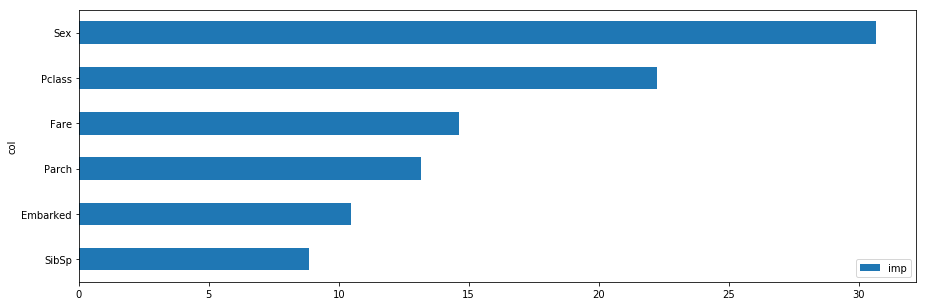

In [89]:
#plot the feature importance scores
feature_importance(catboost_model,X_train)

In [92]:
#Precision and Recall
metrics = ['Precision','Recall','F1','AUC']

eval_metrics = catboost_model.eval_metrics(train_pool, metrics=metrics, plot = True)

for metric in metrics:
  print(str(metric)+":{}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision:0.8885236676836308
Recall:0.7299352941176471
F1:0.8005888485845598
AUC:0.9094382299367834


In [93]:
#we need our test data to look like this one
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,2,1,1,0,18,2
1,0,0,1,0,207,0
2,2,0,0,0,41,2
3,0,0,1,0,189,2
4,2,1,0,0,43,2


In [99]:
#But test dataset has some columns our data has not been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [95]:
#Creating a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [0]:
#Making a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [98]:
#Predictions array is comprised of 0's and 1's (Survived or not survived)
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

In [100]:
#Create a submission dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions #model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [101]:
#how submission have to look like 
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [103]:
#Converting submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')
submission.head()

Converted Survived column to integers.


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [105]:
#Are test and submission data frames the same length?
if len(submission) == len(test):
  print("Submission dataframe has the same length as test ({} rows).".format(len(submission)))
else:
  print("Dataframes mismatched, wont be able to submit to Kaggle")

Submission dataframe has the same length as test (418 rows).


In [106]:
#converting submission dataframe to csv for submission
submission.to_csv('../catboost_submission.csv', index=False)
print("Submission CSV is ready")


Submission CSV is ready


In [107]:
submissions_check = pd.read_csv('../catboost_submission.csv')

submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# New Section